In [5]:
# import libraries
# lib for pre trained model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
# lib for layers
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
# lib for connecting pretrained and created model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
#lib for compile
from tensorflow.keras.optimizers import Adam
# lib for pre processing
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
# lib for spliting i/p and o/p
from sklearn.model_selection import train_test_split
# lib for metrics
from sklearn.metrics import classification_report
# other lib
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [3]:


#!pip install imutils


In [4]:
#!pip install opencv-python


In [31]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [32]:
# r before string will prevent Python from interpreting escape characters.
DIRECTORY = r"D:\HOPE\facemask\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [33]:
dataset_path = r"D:\Hope\Facemask\dataset"  # Use raw string (r"") to avoid escape issues



In [34]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

[INFO] loading images...


In [35]:
from imutils import paths

# Define the path to your dataset
dataset_path = r"D:\Hope\facemask\dataset" 

# List all image paths in the dataset
imagePaths = list(paths.list_images(dataset_path))

# Print the number of images found and a few example paths
print(f"Found {len(imagePaths)} images.")
print("Example image paths:")
print(imagePaths[:5])  # Print first 5 image paths

Found 3846 images.
Example image paths:
['D:\\Hope\\facemask\\dataset\\without_mask\\image_0.png', 'D:\\Hope\\facemask\\dataset\\without_mask\\image_1.png', 'D:\\Hope\\facemask\\dataset\\without_mask\\image_10.png', 'D:\\Hope\\facemask\\dataset\\without_mask\\image_100.png', 'D:\\Hope\\facemask\\dataset\\without_mask\\image_1000.png']


In [39]:
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

C:\Users\USER 10\anaconda3\envs\datasci\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [40]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [13]:
# split the data into training and testing
(trainx, testx, trainy, testy)=train_test_split(data,labels,test_size=0.20,
                                                stratify=labels,random_state=42)

In [14]:
#construct the trianing image generator for data augementation

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range= 0.2,
    shear_range= 0.15,
    horizontal_flip= True,
    fill_mode= 'nearest'
    )

In [45]:
# Construct the validation image generator
val_aug = ImageDataGenerator()

In [47]:
# Create data generators
train_generator = aug.flow(trainx, trainy, batch_size=BS)
val_generator = val_aug.flow(testx, testy, batch_size=BS)

In [48]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [49]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [50]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [51]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [52]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [53]:
# Compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [55]:
# Train the head of the network
print("[INFO] training head...")
H = model.fit(
    train_generator,
    steps_per_epoch=len(trainx) // BS,
    validation_data=val_generator,
    validation_steps=len(testx) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/10
96/96 [==============================] - 199s 2s/step - loss: 0.4416 - accuracy: 0.8380 - val_loss: 0.1813 - val_accuracy: 0.9714
Epoch 2/10
96/96 [==============================] - 181s 2s/step - loss: 0.1586 - accuracy: 0.9642 - val_loss: 0.1019 - val_accuracy: 0.9766
Epoch 3/10
96/96 [==============================] - 182s 2s/step - loss: 0.1115 - accuracy: 0.9701 - val_loss: 0.0843 - val_accuracy: 0.9766
Epoch 4/10
96/96 [==============================] - 157s 2s/step - loss: 0.0822 - accuracy: 0.9777 - val_loss: 0.0728 - val_accuracy: 0.9779
Epoch 5/10
96/96 [==============================] - 167s 2s/step - loss: 0.0748 - accuracy: 0.9803 - val_loss: 0.0675 - val_accuracy: 0.9792
Epoch 6/10
96/96 [==============================] - 163s 2s/step - loss: 0.0687 - accuracy: 0.9800 - val_loss: 0.0678 - val_accuracy: 0.9779
Epoch 7/10
96/96 [==============================] - 168s 2s/step - loss: 0.0613 - accuracy: 0.9849 - val_loss: 0.0626 - val_accura

In [57]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testx, batch_size=BS)

[INFO] evaluating network...
25/25 [==============================] - 46s 1s/step


In [58]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [60]:
# show a nicely formatted classification report
print(classification_report(testy.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.98      0.98       384
without_mask       0.98      0.98      0.98       386

    accuracy                           0.98       770
   macro avg       0.98      0.98      0.98       770
weighted avg       0.98      0.98      0.98       770



In [61]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("Face_Mask_Detector.h5")

[INFO] saving mask detector model...


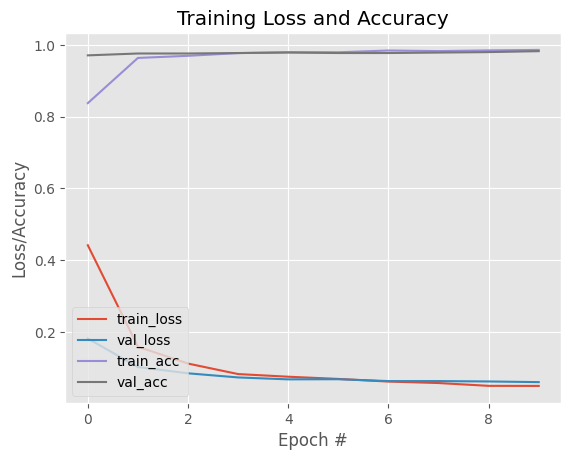

In [62]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")